In [1]:
import pickle

In [2]:
from pathlib import Path

In [3]:
import os
current = Path('.').resolve()
if current.name == 'notebooks':
    os.chdir('..')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import alphamoon

In [6]:
import alphamoon.constants

In [7]:
import numpy as np

In [8]:
import matplotlib.pyplot as plt

In [9]:
input_data_path = alphamoon.constants.RAW_DATA_DIR / 'train.pkl'
with input_data_path.open('rb') as file_handle:
    X, y = pickle.load(file_handle)

In [10]:
one_shot_example = np.where(y[:, 0] == 30)[0][0]

In [11]:
img_w_h = int(np.sqrt(X.shape[1]))

In [12]:
from scipy.ndimage import affine_transform

In [13]:
theta = np.deg2rad(-7)
ry = rx = img_w_h/2


r00 = np.cos(theta)
r01 = -np.sin(theta)
r10 = np.sin(theta)
r11 = np.cos(theta)
r02 = rx - r00*rx - r01*ry
r12 = ry - r10*rx - r11*ry

rotation = np.array([[r00, r01, r02], [r10, r11, r12], [0, 0, 1]])

In [14]:
Sx = 0.9
Sy = 1.1
Tx = -5
Ty = 2

affine2 = np.array([[Sy, 0, Tx], [0, Sx, Ty], [0, 0, 1]])
trans = np.matmul(rotation,  affine2)

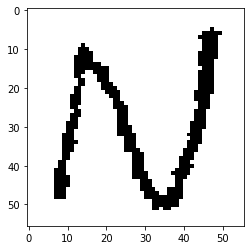

In [15]:
x2 = affine_transform(np.reshape(X[one_shot_example], (img_w_h, img_w_h)),  trans)
plt.imshow(x2, cmap='binary');

In [16]:
x2_ravel = np.ravel(x2)

In [17]:
X_augmented = np.vstack((X, x2_ravel))

In [18]:
y_augmented = np.vstack((y, [30]))

## Train - Test split

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

In [20]:
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=0)

In [21]:
for train_index, test_index in ss.split(X_augmented, y_augmented):
    X_train, X_test = X_augmented[train_index], X_augmented[test_index]
    y_train, y_test = y_augmented[train_index], y_augmented[test_index]

In [22]:
X_train.shape

(20190, 3136)

In [23]:
X_test.shape

(9945, 3136)

In [24]:
from alphamoon.features.build_features import EmbeddingNet, TripletNet
embedding_model = EmbeddingNet(X_train.shape[1], 64, 64)

In [25]:
model = TripletNet(embedding_model)

In [26]:
n_epochs = 10

In [27]:
margin=1

In [28]:
import torch.cuda
import torch.nn
import torch.optim
use_cuda = torch.cuda.is_available()
if use_cuda:
    model.cuda()
loss_fn = torch.nn.TripletMarginWithDistanceLoss(
    distance_function=torch.nn.PairwiseDistance(), margin=margin)
optimizer = torch.optim.Adam(model.parameters())

In [29]:
from alphamoon.data.make_dataset import get_data_loaders, Phase

In [30]:
loaders = get_data_loaders(X_train, y_train, X_test, y_test)

In [31]:
from alphamoon.models.train_model import train

In [32]:
train(n_epochs, loaders, model, optimizer, loss_fn, use_cuda)

Epoch 1


 42%|████████████████████████████████▊                                             | 679/1616 [00:20<00:09, 103.99it/s]

KeyboardInterrupt: 